In [1]:
# import libraries
import pandas as pd
import glob 
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Import course python dictionary
import sys
sys.path.append("/home/clarasmith/Sync/Fall 2025/SI/SI_Data")
from SI_Course_Map import course_map

In [2]:
# Designate path containing data
path = "./Comparison_Data"

# Specify all files that we desire to analyze
files = glob.glob(os.path.join(path, "comparison_scores_*.xlsx"))

# List to hold all data
all_data = []

In [3]:
# Import course voluntary map
Course_Requirements= pd.read_csv("./SI_Course_Maps/SI_Requirements_Map.csv")

In [4]:
#  Convert Course Requirements Year column to categorical
Course_Requirements['Year'] = Course_Requirements['Year'].astype(int).astype('category')


In [5]:
display(Course_Requirements)

,Semester,Year,Course_Name,Requirement
0,Fall,2018,ACCT 2013,Required
1,Fall,2018,ACCT 2023,Required
2,Fall,2018,CHEM 1073,Required
3,Fall,2018,CHEM 1103,Required
4,Fall,2018,CHEM 1123,Required
...,...,...,...,...
150,Spring,2025,CHEM 12103,Required
151,Spring,2025,CHEM 12103 Online,Required
152,Spring,2025,CHEM 14103,Required
153,Spring,2025,CHEM 14203,Required


In [6]:
# Extract just the old→new code mapping
code_map = {old: info['New_Code'] for old, info in course_map.items()}

# Replace Course_Name entries with their new codes where applicable
Course_Requirements['Course_Name'] = Course_Requirements['Course_Name'].replace(code_map)

display(Course_Requirements)


,Semester,Year,Course_Name,Requirement
0,Fall,2018,ACCT 20103,Required
1,Fall,2018,ACCT 20203,Required
2,Fall,2018,CHEM 12103,Required
3,Fall,2018,CHEM 14103,Required
4,Fall,2018,CHEM 14203,Required
...,...,...,...,...
150,Spring,2025,CHEM 12103,Required
151,Spring,2025,CHEM 12103 Online,Required
152,Spring,2025,CHEM 14103,Required
153,Spring,2025,CHEM 14203,Required


In [7]:
for file in files:
    # Extract semester + year
    base = os.path.basename(file)
    semester_str = base.replace("comparison_scores_", "").replace(".xlsx", "")
    semester_str = semester_str.lstrip("_")
    parts = semester_str.split("_")

    # Skip spring 2020
    if len(parts) < 2 or (parts[0].lower() == "spring" and parts[1] == "2020"):
        print(f"Skipping {file}")
        continue

    semester_name, year = parts[0], parts[1]

    # Loop through sheets
    xls = pd.ExcelFile(file)
    for sheet in xls.sheet_names:
        df = pd.read_excel(file, sheet_name=sheet, header=None)

        # --- Non-SI block ---
        non_si_grades = df.loc[6:12, 0].tolist()   # A6:A12
        non_si_numbers = df.loc[6:12, 1].tolist()  # B6:B12

        non_si_df = pd.DataFrame({
            "SI_Group": ["Non-SI"] * len(non_si_grades),
            "Class_Size": ["0"] * len(non_si_grades),   # Non-SI class size = 0
            "Grade": non_si_grades,
            "Number": non_si_numbers,
            "Course_Name": sheet,
            "Semester": semester_name,
            "Year": year
        })

        # --- SI blocks ---
        si_groups = [
            ("1 to 4", 5),  # F column
            ("5 to 9", 7),  # H column
            ("10+", 9)      # J column
        ]

        si_dataframes = []
        for session_label, col_idx in si_groups:
            si_grades = df.loc[6:12, 4].tolist()        # E6:E12
            si_numbers = df.loc[6:12, col_idx].tolist() # F/H/J columns respectively

            si_df = pd.DataFrame({
                "SI_Group": ["SI"] * len(si_grades),
                "Class_Size": [session_label] * len(si_grades),
                "Grade": si_grades,
                "Number": si_numbers,
                "Course_Name": sheet,
                "Semester": semester_name,
                "Year": year
            })
            si_dataframes.append(si_df)

        # Combine all data
        combined = pd.concat([non_si_df] + si_dataframes, ignore_index=True)
        all_data.append(combined)

# Combine everything into a single dataframe
final_df = pd.concat(all_data, ignore_index=True)

# Reorder columns to match your dream dataframe
final_df = final_df[
    ["SI_Group", "Class_Size", "Grade", "Number", "Course_Name", "Semester", "Year"]
]

Skipping ./Comparison_Data/comparison_scores__spring_2020.xlsx


In [8]:
# Define valid grades
valid_grades = {"A", "B", "C", "D", "F", "W"}
# Strip whitespace from grades
final_df["Grade"] = final_df["Grade"].astype(str).str.strip()

# Remove junk grades (e.g., Combined rows, totals)
final_df = final_df[final_df["Grade"].isin(valid_grades)]

# Fill NaN numbers with 0 and convert to int
final_df["Number"] = final_df["Number"].fillna(0).astype(int)

# Reset index for cleanliness
final_df = final_df.reset_index(drop=True)

# Quick check
print(final_df.info())
print(final_df.head(20))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3120 entries, 0 to 3119
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   SI_Group     3120 non-null   object
 1   Class_Size   3120 non-null   object
 2   Grade        3120 non-null   object
 3   Number       3120 non-null   int64 
 4   Course_Name  3120 non-null   object
 5   Semester     3120 non-null   object
 6   Year         3120 non-null   object
dtypes: int64(1), object(6)
memory usage: 170.8+ KB
None
   SI_Group Class_Size Grade  Number Course_Name Semester  Year
0    Non-SI          0     A     132   BIOL 1543   spring  2022
1    Non-SI          0     B     169   BIOL 1543   spring  2022
2    Non-SI          0     C     156   BIOL 1543   spring  2022
3    Non-SI          0     D      64   BIOL 1543   spring  2022
4    Non-SI          0     F      45   BIOL 1543   spring  2022
5    Non-SI          0     W      69   BIOL 1543   spring  2022
6        SI     1 to

In [9]:
print(final_df[
    (final_df["Semester"].str.lower() == "fall") &
    (final_df["Year"] == "2023")
])

final_df = final_df[~final_df["Course_Name"].str.contains("Sheet", case=False, na=False)]

# Replace all instances of the white space ECON honors with a condensed version
final_df['Course_Name'] = final_df['Course_Name'].replace('ECON 2013 H', 'ECON 2143H')


     SI_Group Class_Size Grade  Number Course_Name Semester  Year
2304   Non-SI          0     A       0   ACCT 2013     fall  2023
2305   Non-SI          0     B       1   ACCT 2013     fall  2023
2306   Non-SI          0     C       4   ACCT 2013     fall  2023
2307   Non-SI          0     D       7   ACCT 2013     fall  2023
2308   Non-SI          0     F       3   ACCT 2013     fall  2023
...       ...        ...   ...     ...         ...      ...   ...
2563       SI        10+     B       0     Sheet11     fall  2023
2564       SI        10+     C       0     Sheet11     fall  2023
2565       SI        10+     D       0     Sheet11     fall  2023
2566       SI        10+     F       0     Sheet11     fall  2023
2567       SI        10+     W       0     Sheet11     fall  2023

[264 rows x 7 columns]


In [10]:
# Extract the mapping of old → new course codes
code_map = {old: info['New_Code'] for old, info in course_map.items()}

# Replace in-place (only updates matches)
final_df['Course_Name'] = final_df['Course_Name'].replace(code_map)

# Remove white space 
final_df['Course_Name'] = final_df['Course_Name'].str.strip()

# Display dataframe
display(final_df.head())


,SI_Group,Class_Size,Grade,Number,Course_Name,Semester,Year
0,Non-SI,0,A,132,BIOL 10103,spring,2022
1,Non-SI,0,B,169,BIOL 10103,spring,2022
2,Non-SI,0,C,156,BIOL 10103,spring,2022
3,Non-SI,0,D,64,BIOL 10103,spring,2022
4,Non-SI,0,F,45,BIOL 10103,spring,2022


/var/folders/fp/sbrd1tys4vd2hzst6fyx9qfr0000gn/T/ipykernel_88887/3468577343.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Course_Name", y="Number", hue="SI_Group", data=w_df, ci=None)


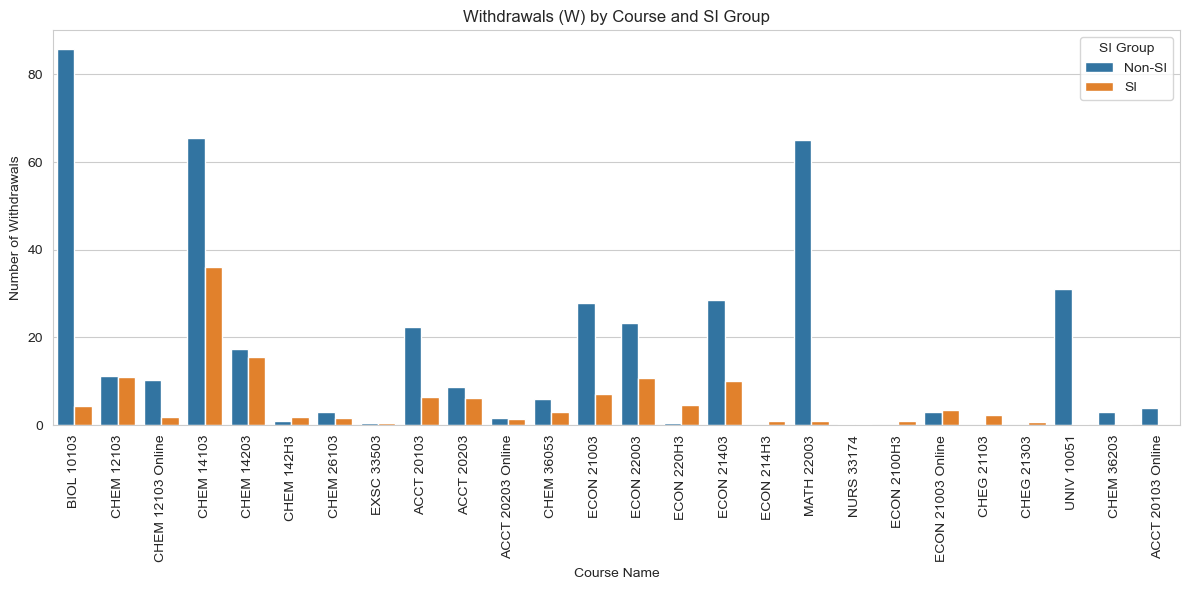

In [11]:
# Filter for Withdrawals
w_df = final_df[final_df['Grade'] == 'W']

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x="Course_Name", y="Number", hue="SI_Group", data=w_df, ci=None)
plt.xticks(rotation=90)
plt.title("Withdrawals (W) by Course and SI Group")
plt.ylabel("Number of Withdrawals")
plt.xlabel("Course Name")
plt.legend(title="SI Group")
plt.tight_layout()
plt.show()

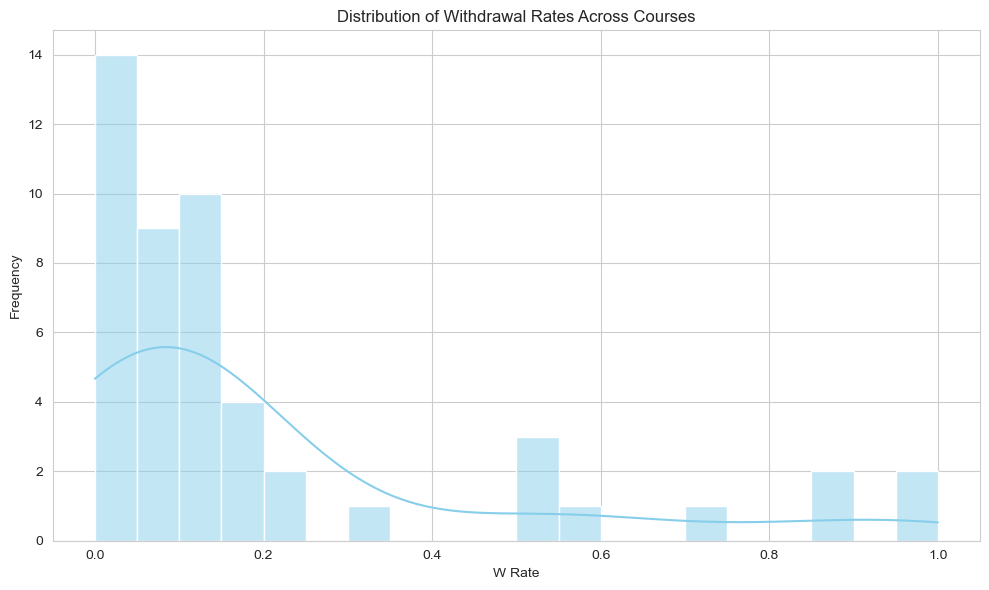

In [12]:
# Recreate merged table so W_Rate exists
totals = final_df.groupby(["Course_Name", "SI_Group"])["Number"].sum().reset_index(name="Total")
w_df = final_df[final_df['Grade'] == 'W']
w_counts = w_df.groupby(["Course_Name", "SI_Group"])["Number"].sum().reset_index(name="W_Count")

merged = pd.merge(totals, w_counts, on=["Course_Name", "SI_Group"], how="left")
merged["W_Rate"] = merged["W_Count"] / merged["Total"]

# Now plot distribution of W_Rate
plt.figure(figsize=(10, 6))
sns.histplot(merged["W_Rate"], bins=20, kde=True, color="skyblue")
plt.title("Distribution of Withdrawal Rates Across Courses")
plt.xlabel("W Rate")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


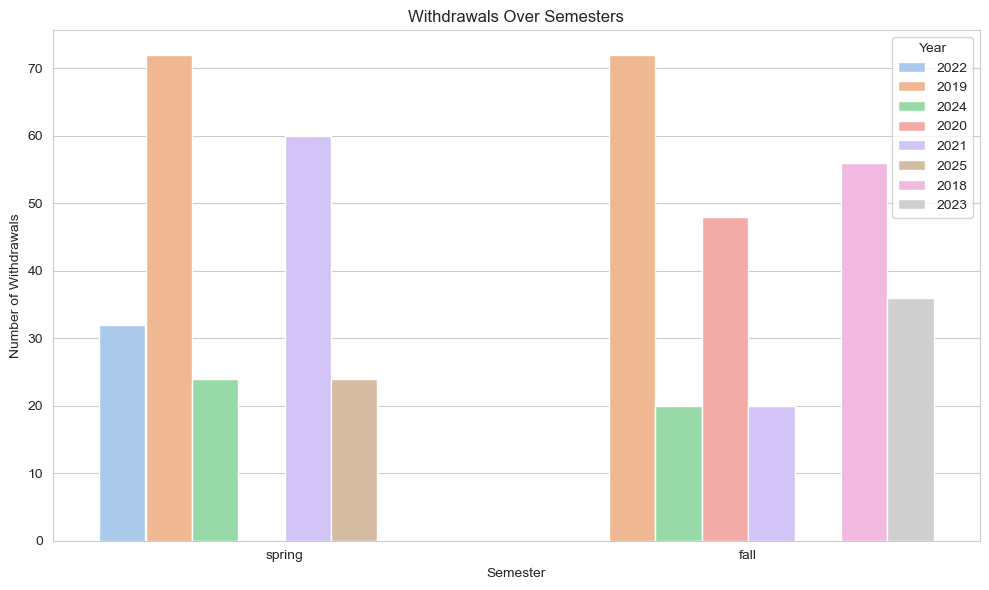

In [13]:
# Filter out "Sheet" courses first
final_df = final_df[~final_df["Course_Name"].str.contains("Sheet", case=False, na=False)]

# Filter for W grades
w_df = final_df[final_df['Grade'] == 'W']

plt.figure(figsize=(10, 6))
sns.countplot(data=w_df, x="Semester", hue="Year", palette="pastel")
plt.title("Withdrawals Over Semesters")
plt.ylabel("Number of Withdrawals")
plt.xlabel("Semester")
plt.legend(title="Year")
plt.tight_layout()
plt.show()

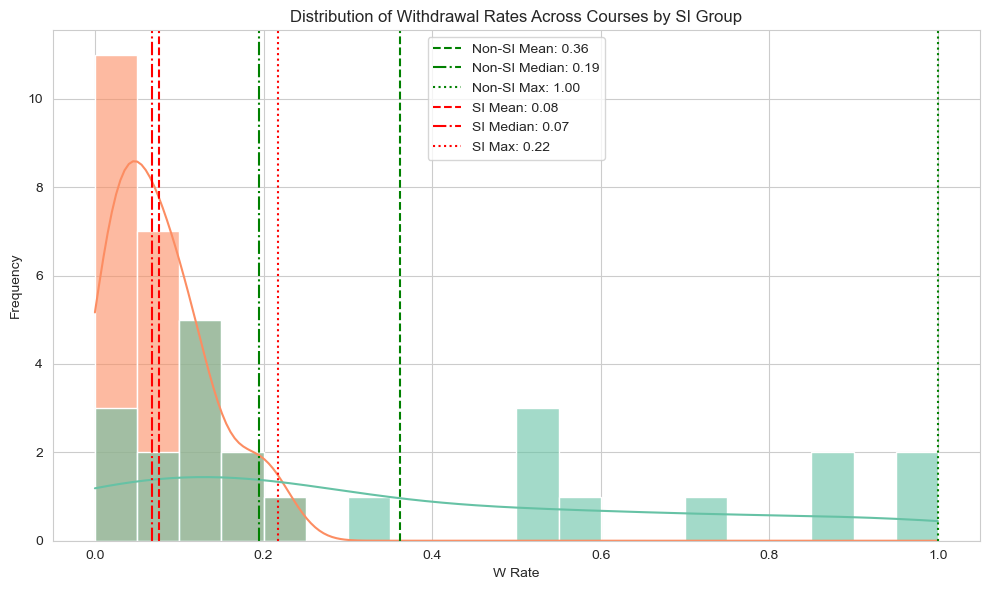

In [14]:
# Non-SI mean withdrawal rate: 0.44 (44%) vs SI mean: 0.07 (7%).
# Non-SI students withdraw at over 6× the rate of SI students.

# Non-SI median: 0.39 (39%) vs SI median: 0.05 (5%).
# Most SI courses have much lower withdrawal rates, not just a few outliers.

# SI maximum withdrawal rate: 0.24 (24%).
# Even the highest SI withdrawal rate is far below the Non-SI average.

# Calculate stats per SI group
group_stats = merged.groupby("SI_Group")["W_Rate"].agg(["mean", "median", "max"]).reset_index()

plt.figure(figsize=(10, 6))

# Histogram with hue by SI_Group
sns.histplot(data=merged, x="W_Rate", hue="SI_Group", bins=20, kde=True, palette="Set2", alpha=0.6)

# Add mean, median, max lines for each SI group
colors = {"SI": "red", "Non-SI": "green"}
linestyles = {"mean": "--", "median": "-.", "max": ":"}

for _, row in group_stats.iterrows():
    plt.axvline(row["mean"], color=colors[row["SI_Group"]], linestyle=linestyles["mean"],
                label=f"{row['SI_Group']} Mean: {row['mean']:.2f}")
    plt.axvline(row["median"], color=colors[row["SI_Group"]], linestyle=linestyles["median"],
                label=f"{row['SI_Group']} Median: {row['median']:.2f}")
    plt.axvline(row["max"], color=colors[row["SI_Group"]], linestyle=linestyles["max"],
                label=f"{row['SI_Group']} Max: {row['max']:.2f}")

plt.title("Distribution of Withdrawal Rates Across Courses by SI Group")
plt.xlabel("W Rate")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


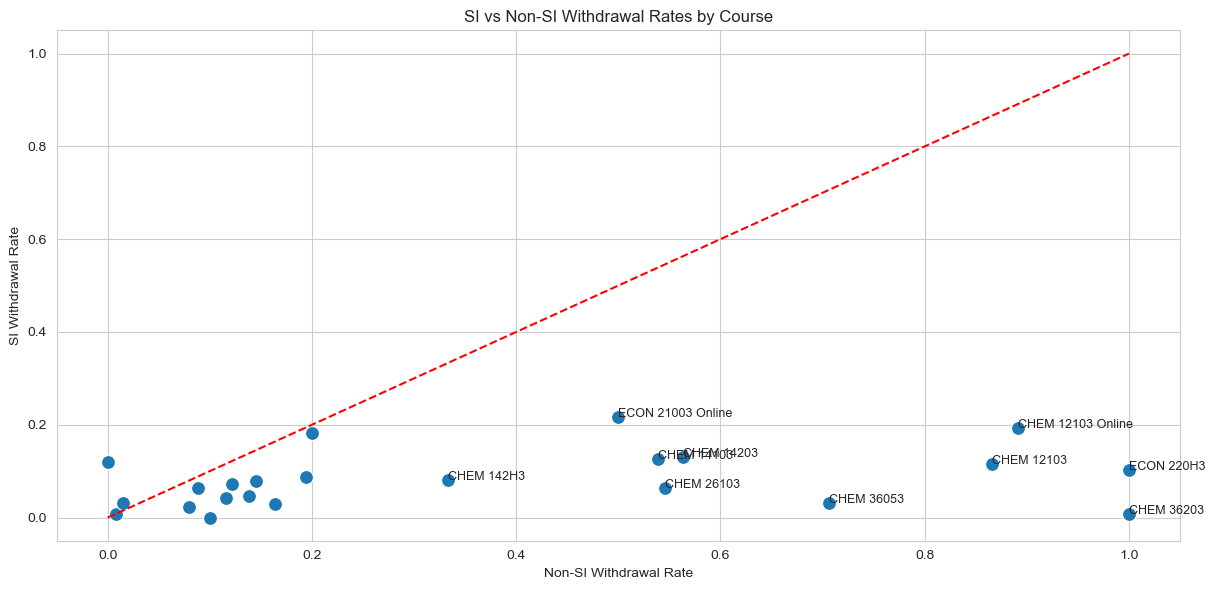

In [15]:
# Most points fall below the red dashed y = x line:
# Indicates that SI withdrawal rates are generally lower than Non-SI rates.
# This suggests SI is broadly effective in reducing withdrawals.

# CHEM courses cluster near (1.0, 0.0):
# Non-SI withdrawal rates around 100% (very high) while SI withdrawal rates are near 0%.
# Probably indicative of the mandatory nature of CHEM SI.

# Red line is Si withdrawal = Non-SI withdrawal

# Ensure merged table exists
totals = final_df.groupby(["Course_Name", "SI_Group"])["Number"].sum().reset_index(name="Total")
w_df = final_df[final_df['Grade'] == 'W']
w_counts = w_df.groupby(["Course_Name", "SI_Group"])["Number"].sum().reset_index(name="W_Count")

merged = pd.merge(totals, w_counts, on=["Course_Name", "SI_Group"], how="left")
merged["W_Rate"] = merged["W_Count"] / merged["Total"]

# Pivot so each course has SI and Non-SI W_Rates side-by-side
pivot = merged.pivot(index="Course_Name", columns="SI_Group", values="W_Rate").reset_index()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=pivot, x="Non-SI", y="SI", s=100)

# Reference line y = x
plt.plot([0, pivot[["Non-SI","SI"]].max().max()], [0, pivot[["Non-SI","SI"]].max().max()],
         color="red", linestyle="--")

plt.title("SI vs Non-SI Withdrawal Rates by Course")
plt.xlabel("Non-SI Withdrawal Rate")
plt.ylabel("SI Withdrawal Rate")
plt.grid(True)
plt.tight_layout()

# Annotate outlier points
for i, row in pivot.iterrows():
    if row["Non-SI"] - row["SI"] > 0.2:  # highlight big differences
        plt.text(row["Non-SI"], row["SI"], row["Course_Name"], fontsize=9)

plt.show()


/var/folders/fp/sbrd1tys4vd2hzst6fyx9qfr0000gn/T/ipykernel_88887/597050874.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pivot, x="Course_Name", y="W_Rate_Diff", palette="coolwarm")


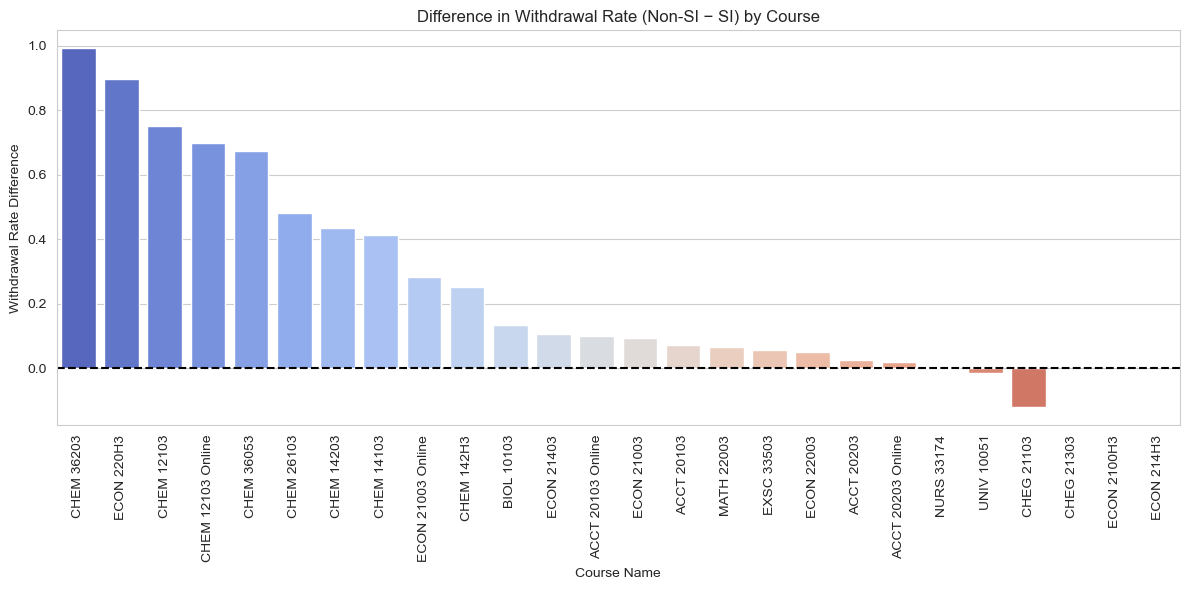

In [16]:
# TLDR: the difference in withdrawal rates for CHEM and ECON are massive. 
# Something weird is going on with CHEG 2113.
# Were the CHEG SI mandatory for struggling students? 

# Calculate merged table if not already done
totals = final_df.groupby(["Course_Name", "SI_Group"])["Number"].sum().reset_index(name="Total")
w_df = final_df[final_df['Grade'] == 'W']
w_counts = w_df.groupby(["Course_Name", "SI_Group"])["Number"].sum().reset_index(name="W_Count")

merged = pd.merge(totals, w_counts, on=["Course_Name", "SI_Group"], how="left")
merged["W_Rate"] = merged["W_Count"] / merged["Total"]

# Pivot to compare SI and Non-SI side-by-side
pivot = merged.pivot(index="Course_Name", columns="SI_Group", values="W_Rate").reset_index()

# Create a new column for the difference (Non-SI - SI)
pivot["W_Rate_Diff"] = pivot["Non-SI"] - pivot["SI"]

# Sort by difference
pivot = pivot.sort_values("W_Rate_Diff", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=pivot, x="Course_Name", y="W_Rate_Diff", palette="coolwarm")
plt.xticks(rotation=90)
plt.axhline(0, color="black", linestyle="--")
plt.title("Difference in Withdrawal Rate (Non-SI − SI) by Course")
plt.ylabel("Withdrawal Rate Difference")
plt.xlabel("Course Name")
plt.tight_layout()
plt.show()


In [17]:
for df in [final_df, Course_Requirements]:
    df['Course_Name'] = df['Course_Name'].str.strip().str.upper()
    df['Semester'] = df['Semester'].str.strip().str.upper()
    df['Year'] = df['Year'].astype(str).str.strip()


In [18]:
Grades_Requirement_Merge = final_df.merge(
    Course_Requirements[['Course_Name', 'Semester', 'Year', 'Requirement']],
    on=['Course_Name', 'Semester', 'Year'],
    how='left'
)

In [19]:
# Voluntary Courses and Grades

# Ensure consistent dtypes
final_df['Year'] = final_df['Year'].astype(str)
Course_Requirements['Year'] = Course_Requirements['Year'].astype(str)

# Clean text fields (remove spaces, normalize case)
for df in [final_df, Course_Requirements]:
    df['Course_Name'] = df['Course_Name'].str.strip().str.upper()
    df['Semester'] = df['Semester'].str.strip().str.upper()

# Merge with indicator to verify matching quality
Grades_Requirement_Merge = final_df.merge(
    Course_Requirements[['Course_Name', 'Semester', 'Year', 'Requirement']],
    on=['Course_Name', 'Semester', 'Year'],
    how='left',
    indicator=True
)

# Display how many rows matched
print(Grades_Requirement_Merge['_merge'].value_counts())

# Drop merge indicator column (optional)
Grades_Requirement_Merge = Grades_Requirement_Merge.drop(columns=['_merge'])


_merge
both          2712
left_only       72
right_only       0
Name: count, dtype: int64


In [20]:
Course_Requirements[Course_Requirements['Course_Name'] == 'CHEM 142H3']

,Semester,Year,Course_Name,Requirement
20,SPRING,2019,CHEM 142H3,Required
51,FALL,2019,CHEM 142H3,Voluntary
61,SPRING,2020,CHEM 142H3,Required
87,SPRING,2021,CHEM 142H3,Required
107,SPRING,2022,CHEM 142H3,Required
124,SPRING,2023,CHEM 142H3,Required


In [21]:
Grades_Requirement_Merge[Grades_Requirement_Merge['Requirement'].isna()]

,SI_Group,Class_Size,Grade,Number,Course_Name,Semester,Year,Requirement
792,Non-SI,0,A,110,ACCT 20203,FALL,2020,NaN
793,Non-SI,0,B,93,ACCT 20203,FALL,2020,NaN
794,Non-SI,0,C,38,ACCT 20203,FALL,2020,NaN
795,Non-SI,0,D,6,ACCT 20203,FALL,2020,NaN
796,Non-SI,0,F,0,ACCT 20203,FALL,2020,NaN
...,...,...,...,...,...,...,...,...
1531,SI,10+,B,29,ECON 214H3,FALL,2018,NaN
1532,SI,10+,C,2,ECON 214H3,FALL,2018,NaN
1533,SI,10+,D,0,ECON 214H3,FALL,2018,NaN
1534,SI,10+,F,0,ECON 214H3,FALL,2018,NaN


In [22]:
missing_courses = Grades_Requirement_Merge.loc[
    Grades_Requirement_Merge['Requirement'].isna(), 'Course_Name'
].unique()

missing_courses

array(['ACCT 20203', 'ECON 21403', 'ECON 214H3'], dtype=object)

In [23]:
# Ask to confirm
print(
    Grades_Requirement_Merge.loc[
        Grades_Requirement_Merge['Requirement'].isna(),
        ['Course_Name', 'Semester', 'Year']
    ].drop_duplicates()
)

# ACCT 20203 = ACCT 2023
# ECON 21403 = ECON 2143
# ECON 214H3 = ECON 2143H

     Course_Name Semester  Year
792   ACCT 20203     FALL  2020
1008  ECON 21403     FALL  2020
1512  ECON 214H3     FALL  2018


In [24]:
# Temporariy drop rows with unknown requirements
Grades_Requirement_Merge_No_NA_Requirement = Grades_Requirement_Merge.dropna(subset=['Requirement'])


In [25]:
Grades_Requirement_Merge_No_NA_Requirement['Requirement'].isna().sum()


0

In [26]:
Grades_Requirement_Merge_No_NA_Requirement.head()

,SI_Group,Class_Size,Grade,Number,Course_Name,Semester,Year,Requirement
0,Non-SI,0,A,132,BIOL 10103,SPRING,2022,Voluntary
1,Non-SI,0,B,169,BIOL 10103,SPRING,2022,Voluntary
2,Non-SI,0,C,156,BIOL 10103,SPRING,2022,Voluntary
3,Non-SI,0,D,64,BIOL 10103,SPRING,2022,Voluntary
4,Non-SI,0,F,45,BIOL 10103,SPRING,2022,Voluntary


In [27]:
# Find courses that appear with both voluntary and required. 
Switch_Courses = (
    Grades_Requirement_Merge_No_NA_Requirement
    .groupby('Course_Name')['Requirement']
    .nunique()
    .reset_index()
)

Switch_Courses = Switch_Courses[Switch_Courses['Requirement'] > 1]['Course_Name']
Switch_Courses

0            ACCT 20103
2            ACCT 20203
3     ACCT 20203 ONLINE
4            BIOL 10103
11           CHEM 142H3
15           ECON 21003
18           ECON 21403
20           ECON 22003
24           NURS 33174
Name: Course_Name, dtype: object

In [28]:
# Subset only those courses
Switch_df = Grades_Requirement_Merge_No_NA_Requirement[
    Grades_Requirement_Merge_No_NA_Requirement['Course_Name'].isin(Switch_Courses)
].copy()

In [29]:
display(Switch_df)

,SI_Group,Class_Size,Grade,Number,Course_Name,Semester,Year,Requirement
0,Non-SI,0,A,132,BIOL 10103,SPRING,2022,Voluntary
1,Non-SI,0,B,169,BIOL 10103,SPRING,2022,Voluntary
2,Non-SI,0,C,156,BIOL 10103,SPRING,2022,Voluntary
3,Non-SI,0,D,64,BIOL 10103,SPRING,2022,Voluntary
4,Non-SI,0,F,45,BIOL 10103,SPRING,2022,Voluntary
...,...,...,...,...,...,...,...,...
2779,SI,10+,B,0,NURS 33174,SPRING,2021,Voluntary
2780,SI,10+,C,0,NURS 33174,SPRING,2021,Voluntary
2781,SI,10+,D,0,NURS 33174,SPRING,2021,Voluntary
2782,SI,10+,F,0,NURS 33174,SPRING,2021,Voluntary


In [30]:
# Compute ABC vs DFW outcomes
Switch_df['Outcome'] = Switch_df['Grade'].apply(lambda g: 'ABC' if g in ['A', 'B', 'C'] else 'DFW')

In [31]:
display(Switch_df)

,SI_Group,Class_Size,Grade,Number,Course_Name,Semester,Year,Requirement,Outcome
0,Non-SI,0,A,132,BIOL 10103,SPRING,2022,Voluntary,ABC
1,Non-SI,0,B,169,BIOL 10103,SPRING,2022,Voluntary,ABC
2,Non-SI,0,C,156,BIOL 10103,SPRING,2022,Voluntary,ABC
3,Non-SI,0,D,64,BIOL 10103,SPRING,2022,Voluntary,DFW
4,Non-SI,0,F,45,BIOL 10103,SPRING,2022,Voluntary,DFW
...,...,...,...,...,...,...,...,...,...
2779,SI,10+,B,0,NURS 33174,SPRING,2021,Voluntary,ABC
2780,SI,10+,C,0,NURS 33174,SPRING,2021,Voluntary,ABC
2781,SI,10+,D,0,NURS 33174,SPRING,2021,Voluntary,DFW
2782,SI,10+,F,0,NURS 33174,SPRING,2021,Voluntary,DFW


In [32]:
# Summarize success rates by course and requirement
Outcome_Summary = (
    Switch_df.groupby(['Course_Name', 'Requirement', 'Outcome'])['Number']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)
Outcome_Summary['Total'] = Outcome_Summary['ABC'] + Outcome_Summary['DFW']
Outcome_Summary['Success_Rate'] = Outcome_Summary['ABC'] / Outcome_Summary['Total']

In [33]:
display(Outcome_Summary)

Outcome,Course_Name,Requirement,ABC,DFW,Total,Success_Rate
0,ACCT 20103,Required,2710,616,3326,0.814793
1,ACCT 20103,Voluntary,1045,180,1225,0.853061
2,ACCT 20203,Required,1109,166,1275,0.869804
3,ACCT 20203,Voluntary,251,13,264,0.950758
4,ACCT 20203 ONLINE,Required,43,19,62,0.693548
5,ACCT 20203 ONLINE,Voluntary,24,5,29,0.827586
6,BIOL 10103,Required,3125,1059,4184,0.746893
7,BIOL 10103,Voluntary,4790,1830,6620,0.723565
8,CHEM 142H3,Required,252,28,280,0.900000
9,CHEM 142H3,Voluntary,13,4,17,0.764706


In [34]:
# Count how many semesters each course spent under each requirement
Semester_Counts = (
    Switch_df.groupby(['Course_Name', 'Requirement'])[['Semester', 'Year']]
    .apply(lambda x: x.drop_duplicates(subset=['Semester', 'Year']).shape[0])
    .reset_index(name='Num_Semesters')
)

# Merge semester counts into Outcome_Summary
Outcome_Summary = Outcome_Summary.merge(Semester_Counts, on=['Course_Name', 'Requirement'], how='left')

In [35]:
display(Outcome_Summary)

,Course_Name,Requirement,ABC,DFW,Total,Success_Rate,Num_Semesters
0,ACCT 20103,Required,2710,616,3326,0.814793,5
1,ACCT 20103,Voluntary,1045,180,1225,0.853061,2
2,ACCT 20203,Required,1109,166,1275,0.869804,3
3,ACCT 20203,Voluntary,251,13,264,0.950758,1
4,ACCT 20203 ONLINE,Required,43,19,62,0.693548,2
5,ACCT 20203 ONLINE,Voluntary,24,5,29,0.827586,1
6,BIOL 10103,Required,3125,1059,4184,0.746893,4
7,BIOL 10103,Voluntary,4790,1830,6620,0.723565,7
8,CHEM 142H3,Required,252,28,280,0.900000,3
9,CHEM 142H3,Voluntary,13,4,17,0.764706,1


In [36]:
Outcome_Summary

,Course_Name,Requirement,ABC,DFW,Total,Success_Rate,Num_Semesters
0,ACCT 20103,Required,2710,616,3326,0.814793,5
1,ACCT 20103,Voluntary,1045,180,1225,0.853061,2
2,ACCT 20203,Required,1109,166,1275,0.869804,3
3,ACCT 20203,Voluntary,251,13,264,0.950758,1
4,ACCT 20203 ONLINE,Required,43,19,62,0.693548,2
5,ACCT 20203 ONLINE,Voluntary,24,5,29,0.827586,1
6,BIOL 10103,Required,3125,1059,4184,0.746893,4
7,BIOL 10103,Voluntary,4790,1830,6620,0.723565,7
8,CHEM 142H3,Required,252,28,280,0.900000,3
9,CHEM 142H3,Voluntary,13,4,17,0.764706,1


In [37]:
# Filter just BIOL 10103 across time
biol_check = (
    Grades_Requirement_Merge_No_NA_Requirement[
        Grades_Requirement_Merge_No_NA_Requirement['Course_Name'] == 'BIOL 10103'
    ][['Course_Name', 'Semester', 'Year', 'Requirement']]
    .drop_duplicates()
    .sort_values(by=['Year', 'Semester'])
)

print(biol_check)


     Course_Name Semester  Year Requirement
1320  BIOL 10103     FALL  2018   Voluntary
1728  BIOL 10103     FALL  2019   Voluntary
264   BIOL 10103   SPRING  2019   Voluntary
816   BIOL 10103     FALL  2020   Voluntary
1056  BIOL 10103     FALL  2021   Voluntary
2520  BIOL 10103   SPRING  2021   Voluntary
0     BIOL 10103   SPRING  2022   Voluntary
2112  BIOL 10103     FALL  2023    Required
2304  BIOL 10103     FALL  2024    Required
648   BIOL 10103   SPRING  2024    Required
1176  BIOL 10103   SPRING  2025    Required


In [38]:
print("In final_df:")
print(final_df[final_df['Course_Name'] == 'BIOL 10103'][['Semester', 'Year']].drop_duplicates())

print("\nIn Course_Requirements:")
print(Course_Requirements[Course_Requirements['Course_Name'] == 'BIOL 10103'][['Semester', 'Year', 'Requirement']].drop_duplicates())


In final_df:
     Semester  Year
0      SPRING  2022
288    SPRING  2019
696    SPRING  2024
864      FALL  2020
1128     FALL  2021
1320   SPRING  2025
1464     FALL  2018
1896     FALL  2019
2328     FALL  2023
2568     FALL  2024
2808   SPRING  2021

In Course_Requirements:
    Semester  Year Requirement
12      FALL  2018   Voluntary
30    SPRING  2019   Voluntary
48      FALL  2019   Voluntary
72    SPRING  2020   Voluntary
79      FALL  2020   Voluntary
93    SPRING  2021   Voluntary
102     FALL  2021   Voluntary
110   SPRING  2022   Voluntary
111     FALL  2022    Required
119   SPRING  2023    Required
130     FALL  2023    Required
139   SPRING  2024    Required
144     FALL  2024    Required
149   SPRING  2025    Required


In [39]:
# Compare average success rates by requirement type
Comparison = (
    Outcome_Summary.groupby('Requirement')
    .agg(
        Mean_Success_Rate=('Success_Rate', 'mean'),
        Num_Courses=('Course_Name', 'nunique'),
        Total_Semesters=('Num_Semesters', 'sum')
    )
    .reset_index()
)

print(Comparison)

  Requirement  Mean_Success_Rate  Num_Courses  Total_Semesters
0    Required           0.826624            9               29
1   Voluntary           0.853083            9               19


In [40]:
# Note: Spring 2023 and Fall 2022 are missing. Fall 2022 is explained. Spring 2023?
final_df[
    (final_df['Course_Name'] == 'BIOL 10103') &
    (final_df['Semester'].str.upper().str.strip() == 'FALL') &
    (final_df['Year'].astype(str).str.strip() == '2022')
]


,SI_Group,Class_Size,Grade,Number,Course_Name,Semester,Year


In [41]:
# Calculate within-course change in success rate (Required - Voluntary)
Improvement = (
    Outcome_Summary.pivot(index='Course_Name', columns='Requirement', values='Success_Rate')
    .assign(Change=lambda x: x['Required'] - x['Voluntary'])
    .reset_index()
)

print(Improvement)


Requirement        Course_Name  Required  Voluntary    Change
0                   ACCT 20103  0.814793   0.853061 -0.038269
1                   ACCT 20203  0.869804   0.950758 -0.080954
2            ACCT 20203 ONLINE  0.693548   0.827586 -0.134038
3                   BIOL 10103  0.746893   0.723565  0.023328
4                   CHEM 142H3  0.900000   0.764706  0.135294
5                   ECON 21003  0.865152   0.856000  0.009152
6                   ECON 21403  0.771338   0.834783 -0.063445
7                   ECON 22003  0.781266   0.892410 -0.111144
8                   NURS 33174  0.996825   0.974874  0.021951


In [42]:
Trend = (
    Grades_Requirement_Merge_No_NA_Requirement
    .assign(Outcome=lambda x: x['Grade'].apply(lambda g: 'ABC' if g in ['A','B','C'] else 'DFW'))
    .groupby(['Year', 'Semester', 'Requirement', 'Outcome'])['Number']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)
Trend['Success_Rate'] = Trend['ABC'] / (Trend['ABC'] + Trend['DFW'])

Trend

Outcome,Year,Semester,Requirement,ABC,DFW,Success_Rate
0,2018,FALL,Required,3798,1097,0.775894
1,2018,FALL,Voluntary,996,422,0.702398
2,2019,FALL,Required,4138,1246,0.768574
3,2019,FALL,Voluntary,2792,418,0.869782
4,2019,SPRING,Required,4353,1224,0.780527
5,2019,SPRING,Voluntary,1267,396,0.761876
6,2020,FALL,Required,1110,532,0.676005
7,2020,FALL,Voluntary,2282,515,0.815874
8,2021,FALL,Required,1247,692,0.643115
9,2021,FALL,Voluntary,1034,382,0.730226


In [43]:
# Calculate proportion of semesters where SI was required
Requirement_Proportion = (
    Grades_Requirement_Merge_No_NA_Requirement
    .groupby('Course_Name')['Requirement']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .reset_index()
)

# Rename for interpretation
Requirement_Proportion = Requirement_Proportion.rename(columns={
    'Required': 'Required_Fraction',
    'Voluntary': 'Voluntary_Fraction'
})

print(Requirement_Proportion)


Requirement        Course_Name  Required_Fraction  Voluntary_Fraction
0                   ACCT 20103           0.714286            0.285714
1            ACCT 20103 ONLINE           0.000000            1.000000
2                   ACCT 20203           0.750000            0.250000
3            ACCT 20203 ONLINE           0.666667            0.333333
4                   BIOL 10103           0.363636            0.636364
5                   CHEG 21103           1.000000            0.000000
6                   CHEG 21303           1.000000            0.000000
7                   CHEM 12103           1.000000            0.000000
8            CHEM 12103 ONLINE           1.000000            0.000000
9                   CHEM 14103           1.000000            0.000000
10                  CHEM 14203           1.000000            0.000000
11                  CHEM 142H3           0.750000            0.250000
12                  CHEM 26103           1.000000            0.000000
13                  

In [44]:
# Compute proportion of semesters where SI was required
Requirement_Proportion = (
    Grades_Requirement_Merge_No_NA_Requirement
    .groupby('Course_Name')['Requirement']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={
        'Required': 'Required_Fraction',
        'Voluntary': 'Voluntary_Fraction'
    })
)

# Make percentage
Requirement_Proportion['Required_%'] = Requirement_Proportion['Required_Fraction'] * 100

# Merge with your outcome summary
Outcome_With_Proportion = Outcome_Summary.merge(
    Requirement_Proportion[['Course_Name', 'Required_Fraction', 'Required_%']],
    on='Course_Name',
    how='left'
)


In [45]:
display(Outcome_With_Proportion)

,Course_Name,Requirement,ABC,DFW,Total,Success_Rate,Num_Semesters,Required_Fraction,Required_%
0,ACCT 20103,Required,2710,616,3326,0.814793,5,0.714286,71.428571
1,ACCT 20103,Voluntary,1045,180,1225,0.853061,2,0.714286,71.428571
2,ACCT 20203,Required,1109,166,1275,0.869804,3,0.750000,75.000000
3,ACCT 20203,Voluntary,251,13,264,0.950758,1,0.750000,75.000000
4,ACCT 20203 ONLINE,Required,43,19,62,0.693548,2,0.666667,66.666667
5,ACCT 20203 ONLINE,Voluntary,24,5,29,0.827586,1,0.666667,66.666667
6,BIOL 10103,Required,3125,1059,4184,0.746893,4,0.363636,36.363636
7,BIOL 10103,Voluntary,4790,1830,6620,0.723565,7,0.363636,36.363636
8,CHEM 142H3,Required,252,28,280,0.900000,3,0.750000,75.000000
9,CHEM 142H3,Voluntary,13,4,17,0.764706,1,0.750000,75.000000


In [46]:
final_df.loc[
    final_df['Course_Name'] == 'CHEM 142H3', 
    ['Year', 'Semester']
].drop_duplicates().sort_values(['Year', 'Semester'])


,Year,Semester
2040,2019,FALL
384,2019,SPRING
2928,2021,SPRING
120,2022,SPRING


In [47]:
# Ensure Year is numeric for sorting
Grades_Requirement_Merge_No_NA_Requirement['Year'] = Grades_Requirement_Merge_No_NA_Requirement['Year'].astype(int)

# Make semester ordering consistent
semester_order = {'SPRING': 1, 'SUMMER': 2, 'FALL': 3}

Grades_Requirement_Merge_No_NA_Requirement['Semester_Order'] = Grades_Requirement_Merge_No_NA_Requirement['Semester'].map(semester_order)

# Earliest appearance (any requirement)
First_Appearance = (
    Grades_Requirement_Merge_No_NA_Requirement
    .sort_values(['Course_Name', 'Year', 'Semester_Order'])
    .groupby('Course_Name')
    .first()
    .reset_index()[['Course_Name', 'Semester', 'Year']]
    .rename(columns={'Semester': 'First_Semester', 'Year': 'First_Year'})
)


/var/folders/fp/sbrd1tys4vd2hzst6fyx9qfr0000gn/T/ipykernel_88887/2474331786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Grades_Requirement_Merge_No_NA_Requirement['Year'] = Grades_Requirement_Merge_No_NA_Requirement['Year'].astype(int)
/var/folders/fp/sbrd1tys4vd2hzst6fyx9qfr0000gn/T/ipykernel_88887/2474331786.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Grades_Requirement_Merge_No_NA_Requirement['Semester_Order'] = Grades_Requirement_Merge_No_NA_Requirement['Semester'].map(semester_order)


In [48]:
First_Required = (
    Grades_Requirement_Merge_No_NA_Requirement[
        Grades_Requirement_Merge_No_NA_Requirement['Requirement'] == 'Required'
    ]
    .sort_values(['Course_Name', 'Year', 'Semester_Order'])
    .groupby('Course_Name')
    .first()
    .reset_index()[['Course_Name', 'Semester', 'Year']]
    .rename(columns={'Semester': 'First_Required_Semester', 'Year': 'First_Required_Year'})
)


In [49]:
Outcome_Extended = (
    Outcome_Summary
    .merge(First_Appearance, on='Course_Name', how='left')
    .merge(First_Required, on='Course_Name', how='left')
)


In [50]:
display(Outcome_Extended)

,Course_Name,Requirement,ABC,DFW,Total,Success_Rate,Num_Semesters,First_Semester,First_Year,First_Required_Semester,First_Required_Year
0,ACCT 20103,Required,2710,616,3326,0.814793,5,FALL,2018,FALL,2018
1,ACCT 20103,Voluntary,1045,180,1225,0.853061,2,FALL,2018,FALL,2018
2,ACCT 20203,Required,1109,166,1275,0.869804,3,FALL,2018,FALL,2018
3,ACCT 20203,Voluntary,251,13,264,0.950758,1,FALL,2018,FALL,2018
4,ACCT 20203 ONLINE,Required,43,19,62,0.693548,2,SPRING,2019,SPRING,2019
5,ACCT 20203 ONLINE,Voluntary,24,5,29,0.827586,1,SPRING,2019,SPRING,2019
6,BIOL 10103,Required,3125,1059,4184,0.746893,4,FALL,2018,FALL,2023
7,BIOL 10103,Voluntary,4790,1830,6620,0.723565,7,FALL,2018,FALL,2023
8,CHEM 142H3,Required,252,28,280,0.900000,3,SPRING,2019,SPRING,2019
9,CHEM 142H3,Voluntary,13,4,17,0.764706,1,SPRING,2019,SPRING,2019


/var/folders/fp/sbrd1tys4vd2hzst6fyx9qfr0000gn/T/ipykernel_88887/421152827.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


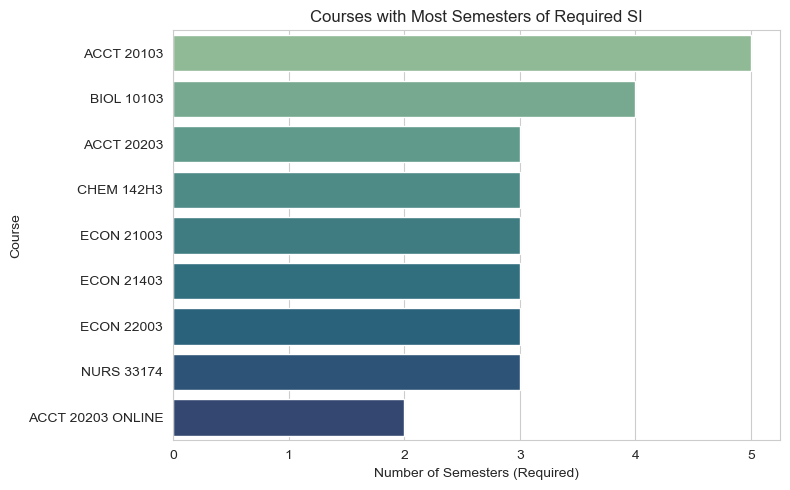

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

top_required = (
    Outcome_Extended[Outcome_Extended['Requirement'] == 'Required']
    .sort_values('Num_Semesters', ascending=False)
    .head(10)
)

plt.figure(figsize=(8,5))
sns.barplot(
    data=top_required,
    x='Num_Semesters',
    y='Course_Name',
    palette='crest'
)
plt.title('Courses with Most Semesters of Required SI')
plt.xlabel('Number of Semesters (Required)')
plt.ylabel('Course')
plt.tight_layout()
plt.show()


/var/folders/fp/sbrd1tys4vd2hzst6fyx9qfr0000gn/T/ipykernel_88887/895108101.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


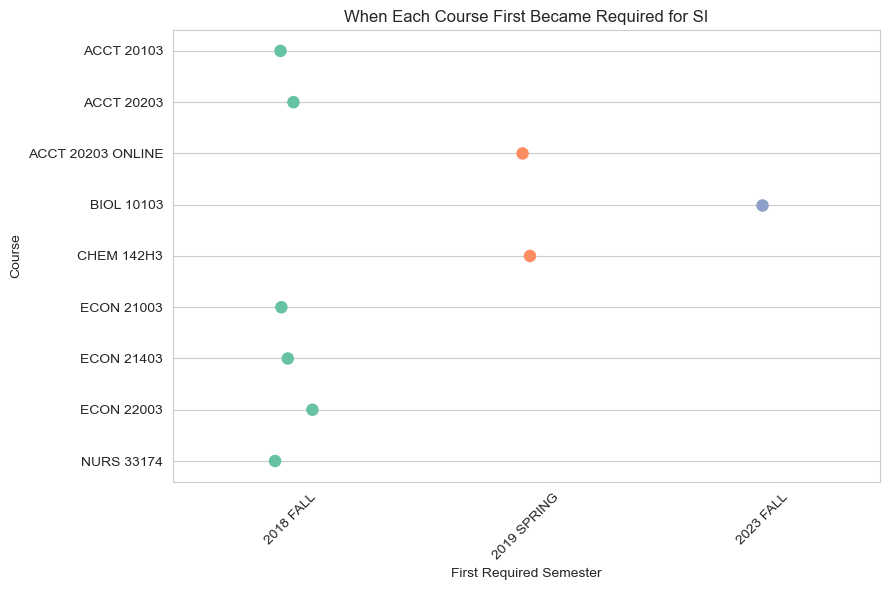

In [52]:
first_required = (
    Outcome_Extended[['Course_Name', 'First_Required_Year', 'First_Required_Semester']]
    .drop_duplicates()
    .dropna(subset=['First_Required_Year'])
)

first_required['First_Required'] = (
    first_required['First_Required_Year'].astype(str)
    + ' ' + first_required['First_Required_Semester']
)

plt.figure(figsize=(9,6))
sns.stripplot(
    data=first_required,
    x='First_Required',
    y='Course_Name',
    order=sorted(first_required['First_Required'].unique(), key=lambda s: (int(s.split()[0]), s.split()[1])),
    palette='Set2',
    size=9
)
plt.title('When Each Course First Became Required for SI')
plt.xlabel('First Required Semester')
plt.ylabel('Course')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [53]:
# Compute the proportion of semesters where SI was required for each course
Requirement_Proportion = (
    Grades_Requirement_Merge_No_NA_Requirement
    .groupby('Course_Name')['Requirement']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={
        'Required': 'Required_Fraction',
        'Voluntary': 'Voluntary_Fraction'
    })
)

# Merge into your extended dataframe
Outcome_Extended = Outcome_Extended.merge(
    Requirement_Proportion[['Course_Name', 'Required_Fraction']],
    on='Course_Name',
    how='left'
)


/var/folders/fp/sbrd1tys4vd2hzst6fyx9qfr0000gn/T/ipykernel_88887/2057525078.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


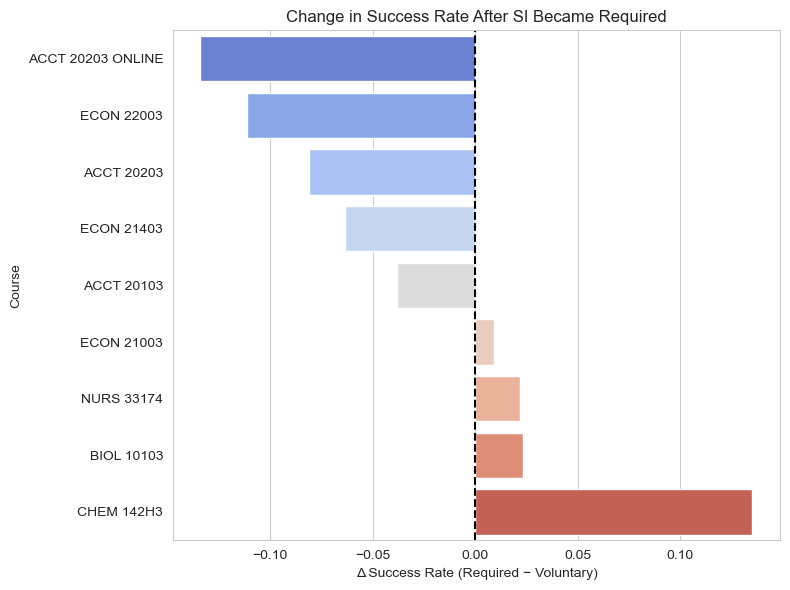

In [54]:
pivot = Outcome_Extended.pivot_table(
    index='Course_Name',
    columns='Requirement',
    values='Success_Rate'
).dropna()

pivot['Change'] = pivot['Required'] - pivot['Voluntary']
pivot = pivot.sort_values('Change')

plt.figure(figsize=(8,6))
sns.barplot(
    data=pivot.reset_index(),
    y='Course_Name',
    x='Change',
    palette='coolwarm',
)
plt.axvline(0, color='black', linestyle='--')
plt.title('Change in Success Rate After SI Became Required')
plt.xlabel('Δ Success Rate (Required − Voluntary)')
plt.ylabel('Course')
plt.tight_layout()
plt.show()
